In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from landaupy import langauss
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from tqdm import tqdm
import warnings
from scipy.stats import chisquare
import sys
sys.path.append("../src")
from event_selections import *
from scipy.integrate import quad

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.simplefilter("error", OptimizeWarning)
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
c_folder="../../data/calibration"
d_folder="../../data/runData"
r_n=305
pulsed=True
p_folder="../../plots/run_"+str(r_n)

In [4]:
pedestals=pd.read_csv(c_folder+"/pedestals.csv", sep=',')
pedestals=pedestals.drop(columns=['pedestal_per_time_sample', 'mean'])

In [5]:
#mips=pd.read_csv("mip.csv", sep=',')
#mips=mips.drop(columns=['eta', 'sigma', 'A'])

In [6]:
def drop_empty(df):
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestals,layer,strip)
            #mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                #el=el[el["adc_sum_end0"]>1.2*peds.iloc[0,-1]] # gets rid of bars where there's no data in end0
                el=el[el["adc_sum_end0"]>(peds.iloc[0,-2]+5*peds.iloc[0,-1])] 
                el=el[el["adc_max_end0"]!=1023]
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-2]
                
                miniped=peds.iloc[0,-1]/8
                
                el.loc[:,"adc_0_end0"]-=miniped
                el.loc[:,"adc_1_end0"]-=miniped
                el.loc[:,"adc_2_end0"]-=miniped
                el.loc[:,"adc_3_end0"]-=miniped
                el.loc[:,"adc_4_end0"]-=miniped
                el.loc[:,"adc_5_end0"]-=miniped
                el.loc[:,"adc_6_end0"]-=miniped
                el.loc[:,"adc_7_end0"]-=miniped
                
                data.extend(el.values.tolist())
    
    df_s=pd.DataFrame(data, columns=['event', 'adc_sum_end0','adc_max_end0',
                                     'adc_0','adc_1','adc_2','adc_3',
                                     'adc_4','adc_5','adc_6','adc_7',
                                     'layer', 'strip'])
    
    return df_s

In [7]:
def langau(x,A,x_mpv,xi,sigma):
    return A*langauss.pdf(x=x, landau_x_mpv=x_mpv,landau_xi=xi,gauss_sigma=sigma)

In [8]:
def cs(n, y):
    return chisquare(n, np.sum(n)/np.sum(y) * y)

In [9]:
electron=pd.read_csv(d_folder+"/run_305_pulse.csv", sep=',')
electron=electron.drop(columns=['tot_end0', 'toa_end0','tot_end1', 'toa_end1', 'adc_max_end1',
                                'pf_spill', 'adc_mean_end0', 'adc_mean_end1', 'pf_ticks','adc_sum_end1',
                               'adc_0_end1','adc_1_end1','adc_2_end1','adc_3_end1',
                               'adc_4_end1','adc_5_end1','adc_6_end1','adc_7_end1'])

#electron=electron.astype({"adc_0_end0":float,"adc_1_end0":float,"adc_2_end0":float,"adc_3_end0":float,
#                          "adc_4_end0":float,"adc_5_end0":float,"adc_6_end0":float,"adc_7_end0":float,})

In [10]:
electron=electron.astype({"adc_0_end0":float,"adc_1_end0":float,"adc_2_end0":float,"adc_3_end0":float,
                          "adc_4_end0":float,"adc_5_end0":float,"adc_6_end0":float,"adc_7_end0":float, 
                          "adc_sum_end0":float})

In [11]:
electron=drop_empty(electron)

In [12]:
len(electron.event.unique())

46383

In [13]:
big=electron.values.tolist()

In [14]:
def calc_integrals(row):
    integral,err=quad(langau, 0,7, (row['A'],row['landau_x_mpv'],row['landau_xi'],row['gauss_sigma']))
    return integral

In [15]:
def get_fit_max(row):
    a=langau(np.arange(0,8,0.01),row['A'],row['landau_x_mpv'],row['landau_xi'],row['gauss_sigma'])
    return max(a)

In [16]:
plt.rcParams["figure.figsize"]=(6,4)
f=0
silent_fails=0
data=[]
n=100

with warnings.catch_warnings():
    for i in tqdm(range(n)):
        try:
            param,pcov=curve_fit(langau,np.arange(0,8),big[i][3:-2], p0=[200,2.0,2,3])

            if param[0]>=5:
                observed=langau(np.arange(0,8), *param)
                expected=np.array(big[i][3:-2])
                _, pval=cs(observed, expected)
                if pval<1e-25 and pval!=0:
                    silent_fails+=1
                    #print(pval)
                    #plt.scatter(np.arange(0,80,10),expected)
                    #plt.plot(np.arange(0,80,0.01),langau(np.arange(0,80,0.01), *param))
                    #plt.show()
                else:
                    line=[big[i][1]]
                    line.append(big[i][2])
                    line.extend(param)
                    data.append(line)
        except:
            f+=1    
            
param_df=pd.DataFrame(data, columns=['adc_sum','adc_max','A','landau_x_mpv', 'landau_xi', 'gauss_sigma'])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:04<00:00,  6.64s/it]


In [17]:
param_df['integral']=param_df.apply(calc_integrals,axis=1)
param_df['fit_max']=param_df.apply(get_fit_max,axis=1)

param_df.head()

C:\Users\GRTI~1\AppData\Local\Temp/ipykernel_5628/964093231.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral,err=quad(langau, 0,7, (row['A'],row['landau_x_mpv'],row['landau_xi'],row['gauss_sigma']))
C:\Users\GRTI~1\AppData\Local\Temp/ipykernel_5628/964093231.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral,err=quad(langau, 0,7, (row['A'],row['landau_x_mpv'],row['landau_xi'],row['gauss_sigma']))
C:\Users\GRTI~1\AppData\Local\Temp/ipykerne

,adc_sum,adc_max,A,landau_x_mpv,landau_xi,gauss_sigma,integral,fit_max
0,531.0,200.0,2382.111795,2.698001,2.090689,1.085761,1167.723416,194.795592
1,88.0,110.0,3278.152425,3.871972,5.411811,0.014491,740.477941,109.430191
2,91.0,113.0,2216.300096,4.732560,0.001501,7.981611,742.594123,110.750488
3,767.0,255.0,2145.226590,2.674153,0.895539,2.067166,1406.836383,255.134692
4,1008.0,297.0,2960.639947,3.544274,1.368013,1.885963,1615.537417,295.549805


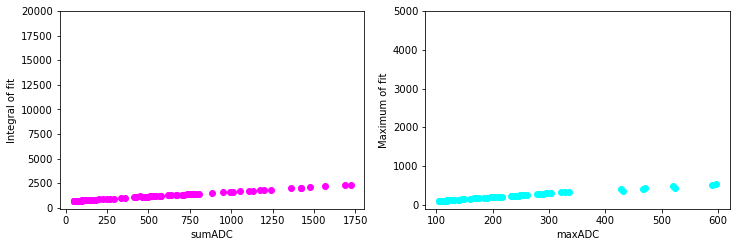

In [18]:
plt.rcParams['figure.figsize']=(12,8)

plt.subplot(2,2,1)
plt.scatter(param_df['adc_sum'], param_df['integral'], c="magenta")
plt.ylabel('Integral of fit')
plt.xlabel('sumADC')
plt.ylim(-100,20000)

plt.subplot(2,2,2)
plt.scatter(param_df['adc_max'], param_df['fit_max'], c="cyan")
plt.ylabel('Maximum of fit')
plt.xlabel('maxADC')
plt.ylim(-100,5000)

# plt.savefig(p_folder+"/after_chisquare.png", bbox_inches='tight')
plt.show()
# plt.scatter(param_df['adc_sum'], param_df['fit_max'], c="lime", marker='x')
# plt.ylim(-100,2000)
# plt.ylabel('Maximum of fit')
# plt.xlabel('sumADC')
# plt.savefig(p_folder+"fitmax_sum.png", bbox_inches='tight')

In [19]:
print("Percentage of bad fits: "+str(round(100*(f+silent_fails)/n))+"%")
print("Of this silent fails are: "+str(round(100*silent_fails/(f+silent_fails)))+"%")

Percentage of bad fits: 11%
Of this silent fails are: 73%
